In [11]:
import os 
import pandas as pd
from main import PreProcessing, Statistics, ExtractionFeatures
from rebalancing_and_select_features import DataLoader, ResamplingPipeline, ModelEvaluator, DataSaver, FileProcessor, FeatureRankingProcessor, DirectoryProcessor, 

# 1. All_extraction_features_by_file

Dans un premier temps, on stock dans le répertoire de l'identifiant du patient et à l'intérieur du répertoire all_extraction_features_by_file pour chaque C3D (et donc condition) toutes les caractéristiques issues de chaque fichier.

In [15]:
def batch_process_and_store_c3d_files(root_directory, statistics_directory):
    concat_stats_df = pd.DataFrame()

    # Walk through the root directory to find all c3d files
    for dirpath, _, filenames in os.walk(root_directory):
        c3d_files = [f for f in filenames if f.endswith('.c3d')] # Filter out only c3d files
        
        if not c3d_files:
            continue

        for file_index, file_name in enumerate(c3d_files): # Process each c3d file of the directory one by one
            file_path = os.path.join(dirpath, file_name)
            print(f"Processing file {file_index + 1}/{len(c3d_files)}: {file_name}") 
            
            # Determine ON/OFF directory based on the file name
            subdirectory = '2_ON' if '_ON_' in file_name else '1_OFF' # ON/OFF directory
            extraction_dir = os.path.join(root_directory, subdirectory, 'extraction_features_by_file') # Extraction directory
            os.makedirs(extraction_dir, exist_ok=True) # Create the extraction directory if it does not exist
            print(f"Created/verified subdirectory: {extraction_dir}")
            
            # Process each c3d file
            detector = PreProcessing(file_path)
            detector.creation_json_grace_c3d()
            detector.extract_data_interval()
            detector.normalize_data()
            detector.decoupage_en_fenetres()
            detector.label_fenetre()
            detector.association_label_fenetre_data()
            data = detector.concat_label_fenetre_data()

            # Instance of Statistics and calculation of the statistics
            stats_processor = Statistics(file_path, data)
            statistiques_resultat = stats_processor.stats()
            concat_stats_df = pd.concat([concat_stats_df, statistiques_resultat], ignore_index=True)

            # Feature extraction
            extraction_features = ExtractionFeatures(data)
            extraction_features.enlever_derniere_ligne_et_colonne_label()
            data_features = extraction_features.dataframe_caracteristiques_final()

            # Saving the extracted features CSV in the created subdirectory
            features_output_file = os.path.join(extraction_dir, f"{os.path.splitext(file_name)[0]}_extraction_features.csv") # Output file path
            data_features.to_csv(features_output_file, index=False) 
            print(f"Features CSV saved to {features_output_file}")

    # Save the statistics DataFrame to the specified statistics directory
    os.makedirs(statistics_directory, exist_ok=True)
    final_stats_file = os.path.join(statistics_directory, 'final_statistics_dernier_fichier.csv') 
    concat_stats_df.to_csv(final_stats_file, index=False)
    print(f"Final statistics have been saved to {final_stats_file}")

    print("All files have been processed.\n")
    return data_features, concat_stats_df

# Example usage:
root_directory = 'C:/Users/antho/Documents/MEMOIRE_M2/P_P_1963-04-01' # Root directory containing all the c3d files
statistics_directory = 'C:/Users/antho/Documents/MEMOIRE_M2/satistiques_audeline/' # Directory to save the statistics CSV file
data_features, concat_stats_df = batch_process_and_store_c3d_files(root_directory, statistics_directory)


Processing file 1/5: P_P_1963-04-01_OFF_DM_10.c3d
Created/verified subdirectory: C:/Users/antho/Documents/MEMOIRE_M2/P_P_1963-04-01\1_OFF\extraction_features_by_file
Features CSV saved to C:/Users/antho/Documents/MEMOIRE_M2/P_P_1963-04-01\1_OFF\extraction_features_by_file\P_P_1963-04-01_OFF_DM_10_extraction_features.csv
Processing file 2/5: P_P_1963-04-01_OFF_DM_13.c3d
Created/verified subdirectory: C:/Users/antho/Documents/MEMOIRE_M2/P_P_1963-04-01\1_OFF\extraction_features_by_file
Features CSV saved to C:/Users/antho/Documents/MEMOIRE_M2/P_P_1963-04-01\1_OFF\extraction_features_by_file\P_P_1963-04-01_OFF_DM_13_extraction_features.csv
Processing file 3/5: P_P_1963-04-01_OFF_DM_16.c3d
Created/verified subdirectory: C:/Users/antho/Documents/MEMOIRE_M2/P_P_1963-04-01\1_OFF\extraction_features_by_file
Features CSV saved to C:/Users/antho/Documents/MEMOIRE_M2/P_P_1963-04-01\1_OFF\extraction_features_by_file\P_P_1963-04-01_OFF_DM_16_extraction_features.csv
Processing file 4/5: P_P_1963-04-0

# 2. all_extraction_ON and OFF

In [8]:
def combine_csv_files(source_directory, output_directory, category, patient_id):
    combined_df = pd.DataFrame()
    extraction_features_dir = os.path.join(source_directory, 'extraction_features_by_file')

    print(f"Combining {category} CSV files from: {extraction_features_dir}")
    
    # Combine all CSV files in the extraction_features_by_file directory
    for file_name in os.listdir(extraction_features_dir):
        if file_name.endswith('_extraction_features.csv'):
            file_path = os.path.join(extraction_features_dir, file_name)
            print(f"Reading CSV file: {file_path}")
            df = pd.read_csv(file_path)
            combined_df = pd.concat([combined_df, df], ignore_index=True)
    
    print(f"All {category} CSV files have been combined. Saving to {output_directory}")
    
    # Save the combined CSV file in the output directory
    os.makedirs(output_directory, exist_ok=True)
    combined_file_path = os.path.join(output_directory, f'{patient_id}_all_extraction_{category}.csv')
    combined_df.to_csv(combined_file_path, index=False)
    
    print(f"Combined {category} CSV saved to {combined_file_path}")

# Example usage:
root_directory = 'C:/Users/antho/Documents/MEMOIRE_M2/P_P_1963-04-01'
patient_id = os.path.basename(root_directory)

# Combine ON CSV files
on_source_directory = os.path.join(root_directory, '2_ON')
on_output_directory = os.path.join(root_directory, '2_ON', 'all_extraction_ON')
print("Starting to combine ON CSV files...")
combine_csv_files(on_source_directory, on_output_directory, 'ON', patient_id)
print("Finished combining ON CSV files.\n")

# Combine OFF CSV files
off_source_directory = os.path.join(root_directory, '1_OFF')
off_output_directory = os.path.join(root_directory, '1_OFF', 'all_extraction_OFF')
print("Starting to combine OFF CSV files...")
combine_csv_files(off_source_directory, off_output_directory, 'OFF', patient_id)
print("Finished combining OFF CSV files.")


Starting to combine ON CSV files...
Combining ON CSV files from: C:/Users/antho/Documents/MEMOIRE_M2/P_P_1963-04-01\2_ON\extraction_features_by_file
Reading CSV file: C:/Users/antho/Documents/MEMOIRE_M2/P_P_1963-04-01\2_ON\extraction_features_by_file\P_P_1963-04-01_ON_DM_12_extraction_features.csv
Reading CSV file: C:/Users/antho/Documents/MEMOIRE_M2/P_P_1963-04-01\2_ON\extraction_features_by_file\P_P_1963-04-01_ON_DM_15_extraction_features.csv
Reading CSV file: C:/Users/antho/Documents/MEMOIRE_M2/P_P_1963-04-01\2_ON\extraction_features_by_file\P_P_1963-04-01_ON_DM_18_extraction_features.csv
Reading CSV file: C:/Users/antho/Documents/MEMOIRE_M2/P_P_1963-04-01\2_ON\extraction_features_by_file\P_P_1963-04-01_ON_DM_3_extraction_features.csv
Reading CSV file: C:/Users/antho/Documents/MEMOIRE_M2/P_P_1963-04-01\2_ON\extraction_features_by_file\P_P_1963-04-01_ON_DM_6_extraction_features.csv
Reading CSV file: C:/Users/antho/Documents/MEMOIRE_M2/P_P_1963-04-01\2_ON\extraction_features_by_file\P

# 3. Global ON et OFF

In [9]:
def combine_on_off_files(on_output_directory, off_output_directory, combined_directory, patient_id):
    on_file_path = os.path.join(on_output_directory, f'{patient_id}_all_extraction_ON.csv')
    off_file_path = os.path.join(off_output_directory, f'{patient_id}_all_extraction_OFF.csv')
    
    print(f"Starting to combine ON and OFF CSV files:\nON: {on_file_path}\nOFF: {off_file_path}")
    
    on_df = pd.read_csv(on_file_path)
    off_df = pd.read_csv(off_file_path)
    
    combined_df = pd.concat([on_df, off_df], ignore_index=True)
    
    os.makedirs(combined_directory, exist_ok=True) # Crée le répertoire s'il n'existe pas
    combined_file_path = os.path.join(combined_directory, f'{patient_id}_all_extraction_ON_OFF.csv')
    combined_df.to_csv(combined_file_path, index=False)
    
    print(f"Finished combining ON and OFF CSV saved to {combined_file_path}\n")

# Example usage:
root_directory = 'C:/Users/antho/Documents/MEMOIRE_M2/P_P_1963-04-01'
patient_id = os.path.basename(root_directory) # extrait le dernier élément du chemin

on_output_directory = os.path.join(root_directory, '2_ON', 'all_extraction_ON')
off_output_directory = os.path.join(root_directory, '1_OFF', 'all_extraction_OFF')
combined_directory = os.path.join(root_directory, '3_ON_OFF')
combine_on_off_files(on_output_directory, off_output_directory, combined_directory, patient_id)


Starting to combine ON and OFF CSV files:
ON: C:/Users/antho/Documents/MEMOIRE_M2/P_P_1963-04-01\2_ON\all_extraction_ON\P_P_1963-04-01_all_extraction_ON.csv
OFF: C:/Users/antho/Documents/MEMOIRE_M2/P_P_1963-04-01\1_OFF\all_extraction_OFF\P_P_1963-04-01_all_extraction_OFF.csv
Finished combining ON and OFF CSV saved to C:/Users/antho/Documents/MEMOIRE_M2/P_P_1963-04-01\3_ON_OFF\P_P_1963-04-01_all_extraction_ON_OFF.csv



# Extraction Feature et Statistics fichier unique

In [10]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from main import PreProcessing, Statistics, ExtractionFeatures
# import numpy as np
# import json
# from scipy.stats import mode, median_abs_deviation, iqr, trim_mean, entropy as ent, skew, kurtosis
# from scipy.signal import welch, correlate, stft
# from statsmodels.tsa.ar_model import AutoReg
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import TimeSeriesSplit
# from scipy.fft import fft, fftfreq
# import entropy as ent
# import os
# # file_path = "C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/R_J_1961-10-0802RJ_OFF/R_J_1961-10-0802RJ_OFF_DM_4.c3d"
# # # Instancier l'objet DetectFog
# # detector = PreProcessing(file_path)
# # # plt.plot(detector.c3d['data']['analogs'][0][0,:])
# # detector.creation_json_grace_c3d()
# # # detector.plot_data_FOG("Foot", "Left", "ACC", "X")

# # detector.extract_data_interval()
# # # detector.plot_data_FOG_start_end("Foot", "Left", "ACC", "X")

# # # detector.plot_data_FOG_start_end("Rectus Femoris", "Left", "ACC", "X")
# # detector.normalize_data() 
# # detector.decoupage_en_fenetres()
# # detector.label_fenetre()
# # detector.association_label_fenetre_data()
# # data = detector.concat_label_fenetre_data()
# # # detector.plot_data_FOG_start_end_final("Foot", "Left", "ACC", "norme",10) # trouver une solution pour le temps

# # # Création de l'instance de Statistics et calcul des statistiques
# # stats_processor = Statistics(file_path,data)
# # statistiques_resultat = stats_processor.stats()


# # extraction_features = ExtractionFeatures(data)
# # extraction_features.enlever_derniere_ligne_et_colonne_label()
# # data_features = extraction_features.dataframe_caracteristiques_final()

# # Définition de la fonction pour traiter chaque fichier C3D
# def process_c3d_file_to_csv_extraction_features(file_path):
#     global_df = pd.DataFrame()
    
    
#     # Instancier l'objet PreProcessing
#     detector = PreProcessing(file_path)
#     detector.creation_json_grace_c3d()
#     detector.extract_data_interval()
#     detector.normalize_data()
#     detector.decoupage_en_fenetres()
#     detector.label_fenetre()
#     detector.association_label_fenetre_data()
#     data = detector.concat_label_fenetre_data()
    
#     # Instance of Statistics and calculation of the statistics
#     stats_processor = Statistics(file_path, data)
#     statistiques_resultat = stats_processor.stats()
#     global_df = pd.concat([global_df, statistiques_resultat], ignore_index=True)
#     # print(f"Statistics computed for {file_name}.")

#     # Extraction des caractéristiques
#     extraction_features = ExtractionFeatures(data)
#     extraction_features.enlever_derniere_ligne_et_colonne_label()
#     data_features = extraction_features.dataframe_caracteristiques_final()

#     return data_features, global_df

# # Chemin du dossier racine où se trouvent les sous-dossiers avec les fichiers C3D
# root_directory = 'C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/'

# # Parcourir chaque sous-dossier et fichier
# for subdir, dirs, files in os.walk(root_directory):
#     for file in files:
#         if file.endswith('.c3d'):
#             file_path = os.path.join(subdir, file)
#             print(f"Traitement du fichier : {file_path}")
#             # Traitement du fichier
#             data_features, global_df = process_c3d_file_to_csv_extraction_features(file_path)
#             # Chemin pour enregistrer le fichier CSV
#             output_file_path = os.path.join(subdir, f"{os.path.splitext(file)[0]}_extraction_features.csv")
#             # Exportation en CSV
#             data_features.to_csv(output_file_path, index=False)
#             print(f"Fichier enregistré : {output_file_path}")





In [ ]:
# chemin_fichier_csv_data_final = "C:/Users/antho/Documents/MEMOIRE_M2/data_final_round.csv"

#     # # # Exporter le DataFrame en tant que fichier CSV
# data_features.to_csv(chemin_fichier_csv_data_final, index=False)

# Extraction caractéristiques et stats batch process

In [7]:
def batch_process_and_store_c3d_files(directory_path, statistics_directory):
    concat_stats_df = pd.DataFrame()

    # List all c3d files in the specified directory
    c3d_files = [f for f in os.listdir(directory_path) if f.endswith('.c3d')]
    
    print(f"Found {len(c3d_files)} c3d files to process.")
    for file_index, file_name in enumerate(c3d_files):
        file_path = os.path.join(directory_path, file_name)
        print(f"Processing file {file_index + 1}/{len(c3d_files)}: {file_name}")
        
        # Determine the subdirectory name based on the file name (excluding the last part after the last underscore)
        subdirectory_name = "_".join(file_name.split("_")[:-2])
        subdirectory_path = os.path.join(directory_path, subdirectory_name)
        
        # Create subdirectory if it doesn't exist
        if not os.path.exists(subdirectory_path):
            os.makedirs(subdirectory_path)
            print(f"Created subdirectory: {subdirectory_path}")
        
        # Process each c3d file
        detector = PreProcessing(file_path)
        detector.creation_json_grace_c3d()
        detector.extract_data_interval()
        detector.normalize_data()
        detector.decoupage_en_fenetres()
        detector.label_fenetre()
        detector.association_label_fenetre_data()
        data = detector.concat_label_fenetre_data()

        # Instance of Statistics and calculation of the statistics
        stats_processor = Statistics(file_path, data)
        statistiques_resultat = stats_processor.stats()
        concat_stats_df = pd.concat([concat_stats_df, statistiques_resultat], ignore_index=True)

        # Feature extraction
        extraction_features = ExtractionFeatures(data)
        extraction_features.enlever_derniere_ligne_et_colonne_label()
        data_features = extraction_features.dataframe_caracteristiques_final()

        # Saving the extracted features CSV in the created subdirectory
        features_output_file = os.path.join(subdirectory_path, f"{os.path.splitext(file_name)[0]}_extraction_features.csv")
        data_features.to_csv(features_output_file, index=False)
        print(f"Features CSV saved to {features_output_file}")

    # Save the statistics DataFrame to the specified statistics directory
    final_stats_file = os.path.join(statistics_directory, 'final_statistics_dernier_fichier.csv')
    concat_stats_df.to_csv(final_stats_file, index=False)
    print(f"Final statistics have been saved to {final_stats_file}")

    print("All files have been processed.")
    return data_features, concat_stats_df

directory_path = 'C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/'
statistics_directory = 'C:/Users/antho/Documents/MEMOIRE_M2/satistiques_audeline/'
data_features, concat_stats_df = batch_process_and_store_c3d_files(directory_path, statistics_directory)

Found 150 c3d files to process.
Processing file 1/150: A_P_1956-02-21_OFF_DM_12.c3d
Features CSV saved to C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/A_P_1956-02-21_OFF\A_P_1956-02-21_OFF_DM_12_extraction_features.csv
Processing file 2/150: A_P_1956-02-21_OFF_DM_15.c3d
Features CSV saved to C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/A_P_1956-02-21_OFF\A_P_1956-02-21_OFF_DM_15_extraction_features.csv
Processing file 3/150: A_P_1956-02-21_OFF_DM_18.c3d
Features CSV saved to C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/A_P_1956-02-21_OFF\A_P_1956-02-21_OFF_DM_18_extraction_features.csv
Processing file 4/150: A_P_1956-02-21_OFF_DM_3.c3d
Features CSV saved to C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/A_P_1956-02-21_OFF\A_P_1956-02-21_OFF_DM_3_extraction_features.csv
Processing file 5/150: A_P_1956-02-21_OFF_DM_6.c3d
Features CSV saved to C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/A_P_1956-02-21_OFF\A_P_1956-02-21_OFF_DM_6_extraction_features.csv
Processing file 6

# Combiner les fichiers CSV de chaque conditions en ON et OFF

##### Filtrer le traitement des sous-répertoire

In [8]:
import os
import pandas as pd
import re

# Chemin du dossier racine et du répertoire de sortie
root_directory = 'C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/'
output_directory = 'C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features/'

# Assurez-vous que le répertoire de sortie existe
os.makedirs(output_directory, exist_ok=True)

# Pattern pour identifier les dossiers pertinents
pattern = r"^[A-Z]_[A-Z]_\d{4}-\d{2}-\d{2}_(ON|OFF)$"

# Parcourir chaque sous-dossier
for subdir, dirs, files in os.walk(root_directory):
    folder_name = os.path.basename(subdir)
    if re.match(pattern, folder_name):
        data_frames_on = []
        data_frames_off = []
        files_processed_on = []
        files_processed_off = []

        # Regrouper les fichiers CSV par ON ou OFF
        for file in files:
            if file.endswith('_extraction_features.csv'):
                file_path = os.path.join(subdir, file)
                if '_ON_' in file:
                    data_frames_on.append(pd.read_csv(file_path))
                    files_processed_on.append(file)
                elif '_OFF_' in file:
                    data_frames_off.append(pd.read_csv(file_path))
                    files_processed_off.append(file)
        
        # Loguer les fichiers traités
        if data_frames_on:
            print(f"Traitement des fichiers ON dans {folder_name}: {files_processed_on}")
            concatenated_df_on = pd.concat(data_frames_on, ignore_index=True)
            output_path_on = os.path.join(output_directory, f"{folder_name}_ON_all_extraction_features.csv")
            concatenated_df_on.to_csv(output_path_on, index=False)
            print(f"Fichier ON concaténé et enregistré : {output_path_on}")

        if data_frames_off:
            print(f"Traitement des fichiers OFF dans {folder_name}: {files_processed_off}")
            concatenated_df_off = pd.concat(data_frames_off, ignore_index=True)
            output_path_off = os.path.join(output_directory, f"{folder_name}_OFF_all_extraction_features.csv")
            concatenated_df_off.to_csv(output_path_off, index=False)
            print(f"Fichier OFF concaténé et enregistré : {output_path_off}")


Traitement des fichiers OFF dans A_P_1956-02-21_OFF: ['A_P_1956-02-21_OFF_DM_12_extraction_features.csv', 'A_P_1956-02-21_OFF_DM_15_extraction_features.csv', 'A_P_1956-02-21_OFF_DM_18_extraction_features.csv', 'A_P_1956-02-21_OFF_DM_3_extraction_features.csv', 'A_P_1956-02-21_OFF_DM_6_extraction_features.csv', 'A_P_1956-02-21_OFF_DM_9_extraction_features.csv', 'A_P_1956-02-21_OFF_DV_11_extraction_features.csv', 'A_P_1956-02-21_OFF_DV_14_extraction_features.csv', 'A_P_1956-02-21_OFF_DV_17_extraction_features.csv', 'A_P_1956-02-21_OFF_DV_2_extraction_features.csv', 'A_P_1956-02-21_OFF_DV_5_extraction_features.csv', 'A_P_1956-02-21_OFF_DV_8_extraction_features.csv', 'A_P_1956-02-21_OFF_ST_10_extraction_features.csv', 'A_P_1956-02-21_OFF_ST_13_extraction_features.csv', 'A_P_1956-02-21_OFF_ST_16_extraction_features.csv', 'A_P_1956-02-21_OFF_ST_1_extraction_features.csv', 'A_P_1956-02-21_OFF_ST_4_extraction_features.csv', 'A_P_1956-02-21_OFF_ST_7_extraction_features.csv']
Fichier OFF concaté

# Combiner les dataframes globaux (ON-OFF)

In [9]:
import os
import pandas as pd

# Chemin du répertoire contenant les fichiers ON et OFF
input_directory = 'C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/ON_OFF_all_features/'
# Chemin du répertoire de sortie pour les fichiers combinés
output_directory = 'C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/all_features_by_patient/'

# Assurez-vous que le répertoire de sortie existe
os.makedirs(output_directory, exist_ok=True)

# Obtenir la liste des fichiers dans le répertoire ON_OFF_all_features
files = [f for f in os.listdir(input_directory) if f.endswith('_all_extraction_features.csv')]

# Dictionnaire pour stocker les dataframes par patient
patient_files = {}

# Classer les fichiers par patient
for file in files:
    # Exemple de nom de fichier : 'P_P_1963-04-01_ON_all_extraction_features.csv'
    patient_base = '_'.join(file.split('_')[:3])  # Extrait 'P_P_1963-04-01'
    
    if patient_base not in patient_files:
        patient_files[patient_base] = []
    patient_files[patient_base].append(file)

# Concaténer les fichiers ON et OFF pour chaque patient
for patient, files in patient_files.items():
    data_frames = []
    for file in files:
        file_path = os.path.join(input_directory, file)
        df = pd.read_csv(file_path)
        data_frames.append(df)
        print(f"Inclure le fichier {file} pour le patient {patient}")
    
    if data_frames:
        concatenated_df = pd.concat(data_frames, ignore_index=True)
        output_path = os.path.join(output_directory, f"{patient}_all_extraction_features.csv")
        concatenated_df.to_csv(output_path, index=False)
        print(f"Fichier regroupé et enregistré pour {patient} : {output_path}")


Inclure le fichier A_P_1956-02-21_OFF_OFF_all_extraction_features.csv pour le patient A_P_1956-02-21
Inclure le fichier A_P_1956-02-21_ON_ON_all_extraction_features.csv pour le patient A_P_1956-02-21
Fichier regroupé et enregistré pour A_P_1956-02-21 : C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/all_features_by_patient/A_P_1956-02-21_all_extraction_features.csv
Inclure le fichier L_J_1942-01-17_OFF_OFF_all_extraction_features.csv pour le patient L_J_1942-01-17
Inclure le fichier L_J_1942-01-17_ON_ON_all_extraction_features.csv pour le patient L_J_1942-01-17
Fichier regroupé et enregistré pour L_J_1942-01-17 : C:/Users/antho/Documents/MEMOIRE_M2/c3d_audeline/all_features_by_patient/L_J_1942-01-17_all_extraction_features.csv
Inclure le fichier P_P_1963-04-01_OFF_OFF_all_extraction_features.csv pour le patient P_P_1963-04-01
Inclure le fichier P_P_1963-04-01_ON_ON_all_extraction_features.csv pour le patient P_P_1963-04-01
Fichier regroupé et enregistré pour P_P_1963-04-01 : C:/Users/

# ____________________________________________________________________________________

# II. Visualisation graphique du signal non borné

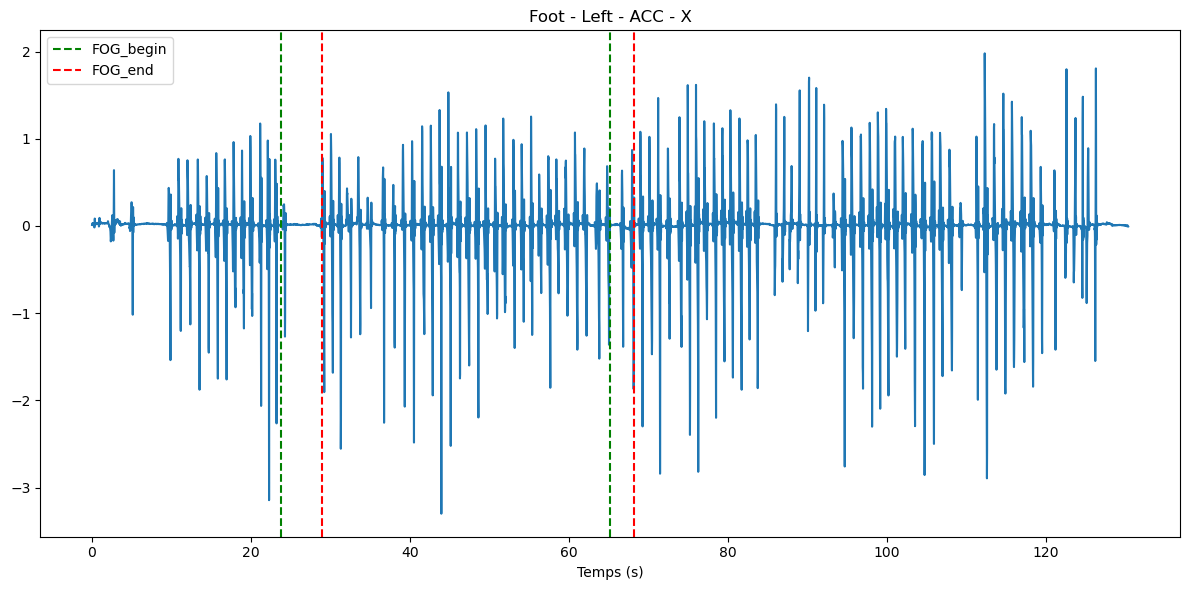

In [19]:
detector.plot_data_FOG("Foot", "Left", "ACC", "X")

# III. Visualisation graphique du signal borné entre début debout et fin debout

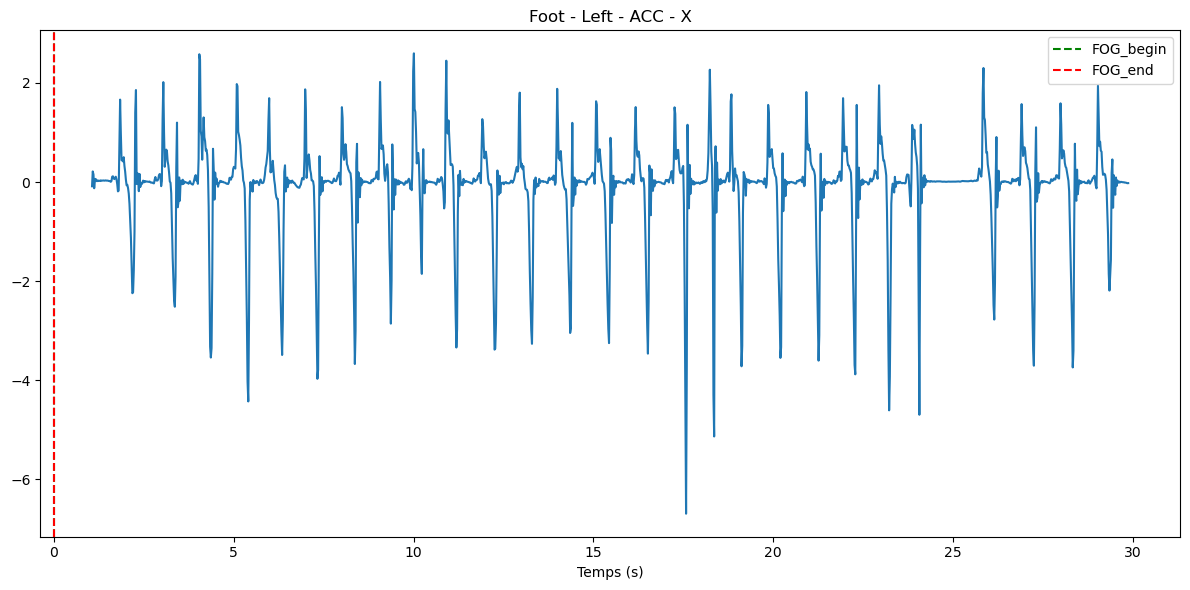

In [16]:
detector.extract_data_interval()
detector.plot_data_FOG_start_end("Foot", "Left", "ACC", "X")

# IV. Normalisation des données par rapport à l'étendue

In [7]:
# detector.normalize_data() 

# V. Fenêtrage

## 1. Découpage en fenêtre de 2sec avec chevauchement à 80%

In [8]:
# detector.decoupage_en_fenetres()
# # Obtenir le dictionnaire global après la découpe en fenêtres
# dictionnaire_global = detector.fenetres_data
# print(dictionnaire_global["FOG"])


{'debut': [25.953332901000977, 45.72666549682617], 'fin': [28.226667404174805, 46.7933349609375]}


In [9]:
# # On peut accéder à toutes les données des fenêtres à ce moment là, car les étiquettes FOG ne sont pas encore associées
# data = detector.fenetres_data["Rectus Femoris"]["Left"]["ACC"]["X"][0:2]
# test = detector.fenetres_data["Rectus Femoris"]["Left"]["ACC"]["X"]

## 2. Association des fenêtres avec les évènements de nonFog,transitionPreFog,preFog,transitionFog, fog, transitionNonFog

In [10]:
# detector.label_fenetre()
# detector.association_label_fenetre_data()

In [11]:
# dictionnaire_global = detector.mix_label_fenetre_data

# #on sélectionne une fenêtre particulière
# a=dictionnaire_global["Rectus Femoris"]["Left"]["ACC"]["X"]["fog"].loc[[54]]
# temps = dictionnaire_global['metadata']["temps"].loc[[54]]
# rf_fog = dictionnaire_global["Rectus Femoris"]["Left"]["ACC"]["X"]["fog"]
# rf_nofog = dictionnaire_global["Rectus Femoris"]["Left"]["ACC"]["X"]["noFog"]

# b = pd.concat([rf_fog, rf_nofog])